# DATA

## What is this notebook about

This notebook builds upon the notebook ``` spacenet6_masking.ipynb ```

``` spacenet6_masking.ipynb ``` is used to generate all the masks for all 3401 training images, using only the PAN images and geojson_buildings files. These masks will be the same regardless of the original data format, hence it is a run-once-and-forget. 


**Loss Function**

This notebook will change the loss function that is being used by the efficientnetb0 model to BinaryCELoss(). Compare against keras_12D, experiment 1H which uses JaccardLoss() and keras_12E experiment 1I which uses BinaryFocalLoss() and keras_12G experiment 1J which uses DiceLoss()

## Setup COLAB and imports

Mount drive to gain access to files

In [ ]:
''' Used to reference the root directory, for directory traversal ''' 
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
mount_dir = '/content/gdrive'
root_dir = '/content/gdrive/My Drive/Colab Notebooks'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


Installations required

In [ ]:
! pip install fiona
! pip install rasterio
! pip install segmentation-models

     |████████████████████████████████| 14.7MB 201kB/s 
     |████████████████████████████████| 18.2MB 36.5MB/s 


Imports required

In [ ]:
''' dealing with .tif files '''
import fiona
import rasterio
from rasterio.mask import mask
from rasterio.plot import show, reshape_as_raster, reshape_as_image

''' plotting images '''
from matplotlib import pyplot as plt
%matplotlib inline

''' traversing directories '''
import os
from pathlib import Path

''' core '''
import numpy as np
import pandas as pd

''' utilities '''
from tqdm import tqdm
import copy
import datetime

''' image processing '''
import tensorflow as tf
from tensorflow.keras.preprocessing import image

''' unet model '''
import segmentation_models as sm
from segmentation_models import Unet
from segmentation_models.losses import JaccardLoss, BinaryFocalLoss, DiceLoss, BinaryCELoss
from segmentation_models.metrics import IOUScore, FScore

Using TensorFlow backend.


Segmentation Models: using `keras` framework.


## Global

### Constants, IMG
For reference the various image types are as such (amax is a rough gauge) based on the train_all data

```
type             shape                dtype       gauge of max value    gauge of min value
PAN              (1, 900, 900)        uint16      1844                  0
PS-RGB           (3, 900, 900)        uint8       255                   0
PS-RGBNIR        (4, 900, 900)        uint16      2047                  0
RGBNIR           (4, 450, 450)        uint16      2047                  0
SAR-Intensity    (4, 900, 900)        float32     92.87763              0.0
```



In [ ]:
''' get the same sequence for random set every time '''
seed = 42
np.random.seed = seed
tf.seed = seed       

''' lookup - define image channels for each image type '''
IMG_TYPE_LOOKUP = {
    'PAN': {'channels': 1, 'dtype': np.uint16}, 
    'PS-RGB': {'channels': 3, 'dtype': np.uint8}, 
    'PS-RGBNIR': {'channels': 4, 'dtype': np.uint16}, 
    'RGBNIR': {'channels': 4, 'dtype': np.uint16}, 
    'SAR-Intensity': {'channels': 4, 'dtype': np.float32}, 
}

''' image height and width we are working with for the whole notebook '''
IMG_HEIGHT = 256    
IMG_WIDTH = 256

''' root of all paths '''
PATH_SPACENET6 = Path(root_dir + '/spacenet6')
PATH_METRICS = PATH_SPACENET6/'metrics_keras_12.csv'

### SIZE, IDX
We will be setting the amount of data that we want to use for train/test
* There are 3401 images for each image type
* The actual spacenet6 "test folder" has only uneseen SAR-Intensity data

Therefore for training purposes, we will pull out our own "test data" from the training set for ease of verifying output 

Random indexes will be used for training and test

In [ ]:
''' set the various sizes we want to use '''
SIZE_ALL = 3401 
SIZE_TRAIN = 800           # CHANGE HERE
SIZE_TEST = 80            # CHANGE HERE
# 800-80, 1600-160, 3200-201

''' set the various idexes we want to use '''
try:
  TRAIN_IDX = np.load(PATH_SPACENET6/('TRAIN_IDX_'+str(SIZE_TRAIN)+'.npy'))
  TEST_IDX = np.load(PATH_SPACENET6/('TEST_IDX_'+str(SIZE_TEST)+'.npy'))
  print('TRAIN/TEST indexes available. Loading ')
except:
  ''' Generate the indexes that we will be using for train and test '''  
  ALL_IDX = np.arange(SIZE_ALL)

  TRAIN_IDX = np.random.choice(ALL_IDX, SIZE_TRAIN, replace=False)
  TRAIN_IDX.sort()

  ALL_IDX_2 = np.setdiff1d(ALL_IDX, TRAIN_IDX)

  TEST_IDX = np.random.choice(ALL_IDX_2, SIZE_TEST, replace=False)
  TEST_IDX.sort()

  np.save(PATH_SPACENET6/('TRAIN_IDX_'+str(SIZE_TRAIN)), TRAIN_IDX)
  np.save(PATH_SPACENET6/('TEST_IDX_'+str(SIZE_TEST)), TEST_IDX)
  print('TRAIN/TEST indexes not available. Generated and saved ')

TRAIN/TEST indexes available. Loading 


### Rotation file
These are the images that have been rotated

In [ ]:
TO_ROTATE = []
PATH_ORIENTATIONS = PATH_SPACENET6/'spacenet6_data_BACKUP/train_all/AOI_11_Rotterdam/SummaryData/SAR_orientations.txt'

orientation_file = open(PATH_ORIENTATIONS, "r")
for line in orientation_file:
  tilename = line.split(' ')[0]
  orientation_flag = int(line.split(' ')[1])

  if orientation_flag == 1:
    TO_ROTATE.append(tilename)

TO_ROTATE.sort()

print('orientation file loaded')

orientation file loaded


## Helper functions

### rotation()

In [ ]:
def rotation(filename, img):
  try:
    if filename.split(IMG_TYPE+'_')[1].split('_tile_')[0] in TO_ROTATE:
      return np.fliplr(np.flipud(img))
    else:
      return img
  except: 
    pass

  try:
    if filename.split('Buildings_')[1].split('_tile_')[0] in TO_ROTATE:
      return np.fliplr(np.flipud(img))
    else:
      return img
  except: 
    pass
      
  
  return img

### plot_XY()

In [ ]:
def plot_XY(plotname, X, Y, X_name, Y_name):
  ix = np.random.randint(0, len(X))
  print("index: {}".format(ix))
  print(plotname, " set")

  fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,5))
  show(reshape_as_raster(X[ix]), ax=ax1, title=X_name)
  show(reshape_as_raster(Y[ix]), ax=ax2, title=Y_name)
  plt.show()

### plot_XY_preds()

In [ ]:
def plot_XY_preds(plotname, X, Y, P, X_name, Y_name, P_name, index=None):
  if index==None:
    ix = np.random.randint(0, len(X))
  else:
    ix = index
  print("index: {}".format(ix))
  print(plotname, " set")

  fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(16,5))

  if X.dtype == 'float32':
    show(reshape_as_raster(  (X[ix] - np.amin(X)) / (np.amax(X) - np.amin(X))   ), ax=ax1, title=X_name)
  else:
    show(reshape_as_raster(X[ix]), ax=ax1, title=X_name)
  show(reshape_as_raster(Y[ix]), ax=ax2, title=Y_name)
  show(reshape_as_raster(P[ix]), ax=ax3, title=P_name)
  plt.show()

### plot_history()

In [ ]:
def plot_history(history):
  fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(16,5))

  ax1.plot(history['loss'], label='train')
  ax1.plot(history['val_loss'], label='val')
  ax1.title.set_text('loss')
  ax1.legend()

  ax2.plot(history['iou_score'], label='train')
  ax2.plot(history['val_iou_score'], label='val')
  ax2.title.set_text('iou_score')
  ax2.legend()

  ax3.plot(history['f1-score'], label='train')
  ax3.plot(history['val_f1-score'], label='val')
  ax3.title.set_text('f1-score')
  ax3.legend()

### store_metrics()
Save into the metrics file

In [ ]:
try: 
  METRICS_HISTORY = pd.read_csv(PATH_METRICS)
except:
  TIMESTAMP = datetime.datetime.now().strftime("%d/%m/%Y %H:%M:%S")
  IMG_TYPE, IMG_ROTATED, MODEL_NAME, MODEL_TYPE, MODEL_PRETRAIN, MODEL_LOSS_FUNCTION, MODEL_COMMENTS = 'trial', 'trial', 'trial', 'trial', 'trial', 'trial', 'trial'
  MODEL_BATCH_SIZE, MODEL_EPOCHS, SIZE_TRAIN, SIZE_TEST, train_loss, train_iou_score, train_f1_score, val_loss, val_iou_score, val_f1_score, test_loss, test_iou_score, test_f1_score = 0,0,0,0,0,0,0,0,0,0,0,0,0

  METRICS_HISTORY = pd.DataFrame(np.array([[TIMESTAMP, IMG_TYPE, IMG_ROTATED, MODEL_NAME, MODEL_TYPE, MODEL_PRETRAIN, MODEL_LOSS_FUNCTION, MODEL_COMMENTS, MODEL_BATCH_SIZE, MODEL_EPOCHS, SIZE_TRAIN, SIZE_TEST, 
                              test_loss, test_iou_score, test_f1_score,
                              val_loss, val_iou_score, val_f1_score, 
                              train_loss, train_iou_score, train_f1_score
                              ]]),
                    columns=['timestamp', 'img_type', 'img_rotated', 'model_name', 'model_type', 'pretrain', 'loss_function', 'comments', 'batch_size', 'epochs', 'size_train', 'size_test', 
                              'test_loss', 'test_iou_score', 'test_f1-score',
                              'val_loss', 'val_iou_score', 'val_f1-score', 
                              'train_loss', 'train_iou_score', 'train_f1-score'
                              ],
                    )
  METRICS_HISTORY.to_csv(PATH_METRICS, index=False)

In [ ]:
def store_metrics(test_loss, test_iou_score, test_f1_score, val_loss, val_iou_score, val_f1_score, train_loss, train_iou_score, train_f1_score, IMG_TYPE, IMG_ROTATED, MODEL_NAME, MODEL_TYPE, MODEL_PRETRAIN, MODEL_LOSS_FUNCTION, MODEL_COMMENTS, MODEL_BATCH_SIZE, MODEL_EPOCHS, SIZE_TRAIN, SIZE_TEST, PATH_METRICS):
  TIMESTAMP = datetime.datetime.now().strftime("%d/%m/%Y %H:%M:%S")

  ''' create another df that looks just like that and concat with ''' 
  new_metrics = pd.DataFrame(np.array([[TIMESTAMP, IMG_TYPE, IMG_ROTATED, MODEL_NAME, MODEL_TYPE, MODEL_PRETRAIN, MODEL_LOSS_FUNCTION, MODEL_COMMENTS, MODEL_BATCH_SIZE, MODEL_EPOCHS, SIZE_TRAIN, SIZE_TEST,
                             test_loss, test_iou_score, test_f1_score,
                             val_loss, val_iou_score, val_f1_score, 
                             train_loss, train_iou_score, train_f1_score                             
                             ]]),
                   columns=['timestamp', 'img_type', 'img_rotated', 'model_name', 'model_type', 'pretrain', 'loss_function', 'comments', 'batch_size', 'epochs', 'size_train', 'size_test', 
                            'test_loss', 'test_iou_score', 'test_f1-score',
                            'val_loss', 'val_iou_score', 'val_f1-score',
                            'train_loss', 'train_iou_score', 'train_f1-score'                            
                            ],
                  )

  new_metrics.to_csv(PATH_METRICS, mode='a', header=False, index=False)
  print("saved model metrics")

## Generator

### gen_input_image_details()
Set the specifications for the image input into the model

In [ ]:
def gen_input_image_details(IMG_TYPE, IMG_ROTATED, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_TYPE_LOOKUP=IMG_TYPE_LOOKUP):
  print('gen_input_image_details()')
  
  IMG_CHANNELS = IMG_TYPE_LOOKUP[IMG_TYPE]['channels']
  IMG_DTYPE_SRC = IMG_TYPE_LOOKUP[IMG_TYPE]['dtype']
  IMG_DTYPE = np.uint8               

  print('IMG_TYPE: {}, IMG_HEIGHT: {}, IMG_WIDTH: {}, IMG_ROTATED: {}, IMG_CHANNELS: {}, IMG_DTYPE_SRC: {}, IMG_DTYPE: {}\n'.format(IMG_TYPE, IMG_HEIGHT, IMG_WIDTH, IMG_ROTATED, IMG_CHANNELS, IMG_DTYPE_SRC, IMG_DTYPE))

  return (IMG_TYPE, IMG_HEIGHT, IMG_WIDTH, IMG_ROTATED, IMG_CHANNELS, IMG_DTYPE_SRC, IMG_DTYPE)

### gen_paths()
Setting the paths that we require, which will change based on the image type and image size specified

In [ ]:
def gen_paths(IMG_TYPE, IMG_ROTATED, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH):
  print('gen_paths()')

  ''' set the original data source folder '''
  PATH_SRC = PATH_SPACENET6/'spacenet6_data_BACKUP/train_all/AOI_11_Rotterdam'
  PATH_SRC_IMAGE = PATH_SRC/IMG_TYPE
  PATH_SRC_MASK = PATH_SRC/'_mask'


  ''' change in accordance to the image type and dimensions '''
  COMBI = IMG_TYPE + '_' + str(IMG_HEIGHT) + 'x' + str(IMG_WIDTH)


  ''' set the directories for this combination '''
  if IMG_ROTATED:
    PATH_DATA = PATH_SPACENET6/('spacenet6_data_rotated/' + COMBI)
    PATH_DATA.mkdir(parents=True, exist_ok=True)
  else:
    PATH_DATA = PATH_SPACENET6/('spacenet6_data/' + COMBI)
    PATH_DATA.mkdir(parents=True, exist_ok=True)

  PATH_IMAGE = PATH_DATA/'image'
  PATH_IMAGE.mkdir(parents=True, exist_ok=True)

  PATH_MASK = PATH_DATA/'mask'
  PATH_MASK.mkdir(parents=True, exist_ok=True)

  PATH_SAMPLE = PATH_DATA/'sample'
  PATH_SAMPLE.mkdir(parents=True, exist_ok=True)

  PATH_SAVED_MODELS = PATH_DATA/'saved_models'
  PATH_SAVED_MODELS.mkdir(parents=True, exist_ok=True)

  print('PATH_SRC: {}, \nPATH_SRC_IMAGE: {}, \nPATH_SRC_MASK: {}, \nPATH_DATA: {}, \nPATH_IMAGE: {}, \nPATH_MASK: {}, \nPATH_SAMPLE: {}, \nPATH_SAVED_MODELS: {}\n'.format(PATH_SRC, PATH_SRC_IMAGE, PATH_SRC_MASK, PATH_DATA, PATH_IMAGE, PATH_MASK, PATH_SAMPLE, PATH_SAVED_MODELS))

  return (PATH_SRC, PATH_SRC_IMAGE, PATH_SRC_MASK, PATH_DATA, PATH_IMAGE, PATH_MASK, PATH_SAMPLE, PATH_SAVED_MODELS)

### gen_resized_images()
This will check if the required resized images have already been created. If not, it will create it.

In [ ]:
def gen_resized_images(PATH_SRC_IMAGE, PATH_SRC_MASK, PATH_IMAGE, PATH_MASK, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH):
  print('gen_resized_images()')
  
  
  def resize_and_save(img_src_path, img_fname, img_save_path):
    img = rasterio.open(img_src_path/img_fname)

    ''' use the metadata from the original image '''
    transform = img.transform
    meta = img.meta.copy()

    ''' resize the image '''
    resized_img = img.read()
    # print(resized_img.shape, resized_img.dtype, 'amax: {}'.format(np.amax(resized_img)), 'amin: {}'.format(np.amin(resized_img)))
    resized_img = reshape_as_image(resized_img)
    # print(resized_img.shape, resized_img.dtype, 'amax: {}'.format(np.amax(resized_img)), 'amin: {}'.format(np.amin(resized_img)))

    resized_img = tf.image.resize(resized_img, [IMG_HEIGHT, IMG_WIDTH], method='nearest', preserve_aspect_ratio=True, antialias=True)
    resized_img = reshape_as_raster(resized_img)
    # print(resized_img.shape, resized_img.dtype, 'amax: {}'.format(np.amax(resized_img)), 'amin: {}'.format(np.amin(resized_img)))

    resized_img = rotation(img_fname, resized_img)


    ''' update metadata with new size '''
    meta.update({"transform": transform,
                "height": resized_img.shape[1],
                "width": resized_img.shape[2]
                })

    ''' write the resized image to a new geotiff '''
    with rasterio.open(img_save_path/img_fname, 'w', **meta) as dst:
      dst.write(resized_img)




  ''' Verify contents in source directory are present and assign to iterator '''
  src_image_ids = next(os.walk(PATH_SRC_IMAGE))[2]
  src_image_ids.sort()
  # print('len(src_image_ids): {}'.format(len(src_image_ids)))
  # print(src_image_ids[:3])

  src_mask_ids = next(os.walk(PATH_SRC_MASK))[2]
  src_mask_ids.sort()
  # print('len(src_mask_ids): {}'.format(len(src_mask_ids)))
  # print(src_mask_ids[:3])


  ''' check the target directory for existing files '''
  existing_image_ids = next(os.walk(PATH_IMAGE))[2]
  existing_image_ids.sort()
  # print('len(existing_image_ids): {}'.format(len(existing_image_ids)))
  # print(existing_image_ids[:3])

  existing_mask_ids = next(os.walk(PATH_MASK))[2]
  existing_mask_ids.sort()
  # print('len(existing_mask_ids): {}'.format(len(existing_mask_ids)))
  # print(existing_mask_ids[:3])


  ''' check if resized files already exist, else create them '''
  if (existing_image_ids == src_image_ids) and (existing_mask_ids == src_mask_ids): 
    print('Resized images and masks available\n')
    pass
  else:
    print('Resized images and masks not available')
    print('Resizing image')
    for n, id in tqdm(enumerate(src_image_ids), total=len(src_image_ids), position=0, leave=True):
      resize_and_save(PATH_SRC_IMAGE, id, PATH_IMAGE)
    print('Finished resizing image')

    print('Resizing mask')
    for n, id in tqdm(enumerate(src_mask_ids), total=len(src_mask_ids), position=0, leave=True):
      resize_and_save(PATH_SRC_MASK, id, PATH_MASK)
    print('Finished resizing mask')

    print('Resized images and masks generated\n')

### gen_train_test_set()
This will return the train test set 

In [ ]:
def gen_train_test_set(PATH_IMAGE, PATH_MASK, IMG_CHANNELS, IMG_DTYPE_SRC, TRAIN_IDX, TEST_IDX, SIZE_TRAIN=SIZE_TRAIN, SIZE_TEST=SIZE_TEST, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH):
  print('gen_train_test_set()')  
  
  X_train_sample_fname = 'sample_X_train_{}.npy'.format(SIZE_TRAIN)
  Y_train_sample_fname = 'sample_Y_train_{}.npy'.format(SIZE_TRAIN)
  X_test_sample_fname = 'sample_X_test_{}.npy'.format(SIZE_TEST)
  Y_test_sample_fname = 'sample_Y_test_{}.npy'.format(SIZE_TEST)
  
  
  ''' load sample data if present '''
  try:
    X_train = np.load(PATH_SAMPLE/X_train_sample_fname).reshape((SIZE_TRAIN,IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS))
    Y_train = np.load(PATH_SAMPLE/Y_train_sample_fname).reshape((SIZE_TRAIN,IMG_HEIGHT,IMG_WIDTH,1))
    X_test = np.load(PATH_SAMPLE/X_test_sample_fname).reshape((SIZE_TEST,IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS))
    Y_test = np.load(PATH_SAMPLE/Y_test_sample_fname).reshape((SIZE_TEST,IMG_HEIGHT,IMG_WIDTH,1))
    print('Sample data available. Loaded sample data\n')

  except:
    ''' get the ids/filenames that we need, based on the random index allocation to avoid grouping '''
    ''' X are image files, Y are mask files '''
    print('Sample data not available')
    all_img_ids = next(os.walk(PATH_IMAGE))[2]
    all_img_ids.sort()
    all_img_ids = np.array(all_img_ids)

    all_mask_ids = next(os.walk(PATH_MASK))[2]
    all_mask_ids.sort()
    all_mask_ids = np.array(all_mask_ids)

    X_train_ids = all_img_ids[TRAIN_IDX]
    X_train_ids.sort()
    Y_train_ids = all_mask_ids[TRAIN_IDX]
    Y_train_ids.sort()

    X_test_ids = all_img_ids[TEST_IDX]
    X_test_ids.sort()
    Y_test_ids = all_mask_ids[TEST_IDX]
    Y_test_ids.sort()

    # print(len(all_img_ids))
    # print(all_img_ids[:3])
    # print(len(all_mask_ids))
    # print(all_mask_ids[:3])
    # print(len(X_train_ids))
    # print(X_train_ids[:3])
    # print(len(Y_train_ids))
    # print(Y_train_ids[:3])
    # print(len(X_test_ids))
    # print(X_test_ids[:3])
    # print(len(Y_test_ids))
    # print(Y_test_ids[:3])


    ''' prepare numpy arrays to store converted image and mask files. Image files will need to be converted to IMG_DTYPE_SRC and mask files will be converted to np.bool '''
    X_train = np.zeros((len(X_train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=IMG_DTYPE_SRC) 
    Y_train = np.zeros((len(Y_train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    X_test = np.zeros((len(X_test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=IMG_DTYPE_SRC) 
    Y_test = np.zeros((len(Y_test_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

    # print('X_train', X_train.shape, X_train.dtype)
    # print('Y_train', Y_train.shape, Y_train.dtype)
    # print('X_test', X_test.shape, X_test.dtype)
    # print('Y_test', Y_test.shape, Y_test.dtype)

    ''' actually format the imaegs into the correct data shape and type '''
    print('formatting training images')
    for n, id in tqdm(enumerate(X_train_ids), total=len(X_train_ids), position=0, leave=True):
      img = rasterio.open(PATH_IMAGE/id).read()
      img = reshape_as_image(img)
      X_train[n] = img
    print('Finished formatting training images')

    print('formatting training masks')
    for n, id in tqdm(enumerate(Y_train_ids), total=len(Y_train_ids), position=0, leave=True):
      img = rasterio.open(PATH_MASK/id).read()
      img = reshape_as_image(img)
      img = img.astype(np.bool) 
      Y_train[n] = img
    print('Finished formatting training masks')

    print('formatting test images')
    for n, id in tqdm(enumerate(X_test_ids), total=len(X_test_ids), position=0, leave=True):
      img = rasterio.open(PATH_IMAGE/id).read()
      img = reshape_as_image(img)
      X_test[n] = img
    print('Finished formatting test images')

    print('formatting test masks')
    for n, id in tqdm(enumerate(Y_test_ids), total=len(Y_test_ids), position=0, leave=True):
      img = rasterio.open(PATH_MASK/id).read()
      img = reshape_as_image(img)
      img = img.astype(np.bool) 
      Y_test[n] = img
    print('Finished formatting test masks')  


    np.save(PATH_SAMPLE/X_train_sample_fname, X_train.ravel())
    np.save(PATH_SAMPLE/Y_train_sample_fname, Y_train.ravel())
    np.save(PATH_SAMPLE/X_test_sample_fname, X_test.ravel())
    np.save(PATH_SAMPLE/Y_test_sample_fname, Y_test.ravel())

    print('Sample data generated and saved\n')

  return (X_train, Y_train, X_test, Y_test)

### gen_model()
This will generate a basic model to use 

In [ ]:
def gen_model(MODEL_LOSS, MODEL_BATCH_SIZE, MODEL_EPOCHS, MODEL_TYPE, MODEL_PRETRAIN, MODEL_LOSS_FUNCTION, IMG_CHANNELS, MODEL_ID=None, MODEL_COMMENTS=''): 
  MODEL_OPTIMIZER = 'adam'
  MODEL_LOSS = JaccardLoss()                                      # CHANGE HERE
  MODEL_METRICS =[IOUScore(), FScore()]
  MODEL_VAL_SPLIT = 0.1
  MODEL_VAL_OFFSET = int(SIZE_TRAIN*(1-MODEL_VAL_SPLIT))    
  MODEL_BATCH_SIZE = MODEL_BATCH_SIZE
  MODEL_EPOCHS = MODEL_EPOCHS                                               # CHANGE HERE

  MODEL_TYPE = 'segmentation-models Unet'
  MODEL_PRETRAIN = MODEL_PRETRAIN                                     # CHANGE HERE
  MODEL_LOSS_FUNCTION = MODEL_LOSS_FUNCTION                           # CHANGE HERE
  MODEL_COMMENTS = MODEL_COMMENTS

  if MODEL_ID == None:
    MODEL_NAME = 'MODEL_{}__PRETRAIN_{}__LOSS_{}__EPOCH_{}__TRAIN_{}__TEST_{}'.format(MODEL_TYPE, MODEL_PRETRAIN, MODEL_LOSS_FUNCTION, MODEL_EPOCHS, SIZE_TRAIN, SIZE_TEST)
  else:
    MODEL_NAME = 'ID_{}__MODEL_{}__PRETRAIN_{}__LOSS_{}__EPOCH_{}__TRAIN_{}__TEST_{}'.format(MODEL_ID, MODEL_TYPE, MODEL_PRETRAIN, MODEL_LOSS_FUNCTION, MODEL_EPOCHS, SIZE_TRAIN, SIZE_TEST)

  model = Unet(backbone_name=MODEL_PRETRAIN, encoder_weights=None, input_shape=(None, None, IMG_CHANNELS))
  model.compile(optimizer=MODEL_OPTIMIZER, loss=MODEL_LOSS, metrics=MODEL_METRICS)

  return (MODEL_OPTIMIZER, MODEL_LOSS, MODEL_METRICS, MODEL_VAL_SPLIT, MODEL_VAL_OFFSET, MODEL_BATCH_SIZE, MODEL_EPOCHS, MODEL_TYPE, MODEL_PRETRAIN, MODEL_LOSS_FUNCTION, MODEL_COMMENTS, MODEL_ID, MODEL_NAME, model)


### gen_model_results()
This will generate a basic model to use 

In [ ]:
def gen_model_results(PATH_SAVED_MODELS, MODEL_NAME, X_train, Y_train, MODEL_BATCH_SIZE, MODEL_EPOCHS, MODEL_VAL_SPLIT, load_weights_filename='', load_weights_epochs=0, save_model=False):
  checkpointer = tf.keras.callbacks.ModelCheckpoint( PATH_SAVED_MODELS/(MODEL_NAME+'_WEIGHTS.h5'), verbose=1, save_best_only=True)
  callbacks = [tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss', mode='min')]   

  if load_weights_filename == '':
    print('No weights loaded. Training new model')
    results = model.fit(X_train, Y_train, batch_size=MODEL_BATCH_SIZE, epochs=MODEL_EPOCHS, validation_split=MODEL_VAL_SPLIT, callbacks=callbacks)
  else:
    model.load_weights(str(PATH_SAVED_MODELS/load_weights_filename))

    # load_weights_epochs: the extra epochs to train for, after loading in weights. 
    if load_weights_epochs == 0:
      print('Just loading weights')
      results = None
    else:
      print('Weights loaded, training for extra {} epochs'.format(load_weights_epochs))
      results = model.fit(X_train, Y_train, batch_size=MODEL_BATCH_SIZE, epochs=load_weights_epochs, validation_split=MODEL_VAL_SPLIT, callbacks=callbacks)

  if save_model == True:
    # model.save(str(PATH_SAVED_MODELS/(MODEL_NAME+'.h5')))
    model.save_weights(str(PATH_SAVED_MODELS/(MODEL_NAME+'_WEIGHTS.h5')))
    print('model saved')
  
  return (results, model)

### gen_predictions()
This will generate the predictions based on a trained model

In [ ]:
def gen_predictions(model, X_train, Y_train, X_test, Y_test, MODEL_VAL_OFFSET, IMG_TYPE, IMG_ROTATED, MODEL_NAME, MODEL_TYPE, MODEL_PRETRAIN, MODEL_LOSS_FUNCTION, MODEL_COMMENTS, MODEL_BATCH_SIZE, MODEL_EPOCHS, SIZE_TRAIN=SIZE_TRAIN, SIZE_TEST=SIZE_TEST, PATH_METRICS=PATH_METRICS):
  ''' split train, val 90-10. validation_split takes the percentage from the back '''
  preds_train = model.predict(X_train[:MODEL_VAL_OFFSET], verbose=1)
  preds_val = model.predict(X_train[MODEL_VAL_OFFSET:], verbose=1)
  preds_test = model.predict(X_test, verbose=1)

  preds_train_t = (preds_train > 0.5).astype(np.uint8)
  preds_val_t = (preds_val > 0.5).astype(np.uint8)
  preds_test_t = (preds_test > 0.5).astype(np.uint8)


  ''' evaluation of prediction '''
  metric_names = model.metrics_names
  
  print("train set evaluation")
  train_metrics = model.evaluate(X_train[:MODEL_VAL_OFFSET], Y_train[:MODEL_VAL_OFFSET])
  for x in range(len(metric_names)):
    print(metric_names[x], ': ', train_metrics[x])

  print("\nvalidation set evaluation")
  val_metrics = model.evaluate(X_train[MODEL_VAL_OFFSET:], X_train[MODEL_VAL_OFFSET:])
  for x in range(len(metric_names)):
    print(metric_names[x], ': ', val_metrics[x])

  print("\ntest set evaluation")
  test_metrics = model.evaluate(X_test, Y_test)
  for x in range(len(metric_names)):
    print(metric_names[x], ': ', test_metrics[x])

  store_metrics(test_metrics[0], test_metrics[1], test_metrics[2], val_metrics[0], val_metrics[1], val_metrics[2], train_metrics[0], train_metrics[1], train_metrics[2], IMG_TYPE, IMG_ROTATED, MODEL_NAME, MODEL_TYPE, MODEL_PRETRAIN, MODEL_LOSS_FUNCTION, MODEL_COMMENTS, MODEL_BATCH_SIZE, MODEL_EPOCHS, SIZE_TRAIN, SIZE_TEST, PATH_METRICS)

  return (preds_train_t, preds_val_t, preds_test_t)

## Bring in the SAR data, both rotated and un-rotated
The geotiff metadata has probably been copied wrongly for now for rotated images

In [ ]:
''' run when changing parameters '''
IMG_TYPE, IMG_WIDTH, IMG_HEIGHT, IMG_ROTATED, IMG_CHANNELS, IMG_DTYPE_SRC, IMG_DTYPE = gen_input_image_details('SAR-Intensity', False)       # CHANGE HERE

PATH_SRC, PATH_SRC_IMAGE, PATH_SRC_MASK, PATH_DATA, PATH_IMAGE, PATH_MASK, PATH_SAMPLE, PATH_SAVED_MODELS = gen_paths(IMG_TYPE, IMG_ROTATED)
gen_resized_images(PATH_SRC_IMAGE, PATH_SRC_MASK, PATH_IMAGE, PATH_MASK)
X_train_no_rotate, Y_train_no_rotate, X_test_no_rotate, Y_test_no_rotate = gen_train_test_set(PATH_IMAGE, PATH_MASK, IMG_CHANNELS, IMG_DTYPE_SRC, TRAIN_IDX, TEST_IDX)

gen_input_image_details()
IMG_TYPE: SAR-Intensity, IMG_HEIGHT: 256, IMG_WIDTH: 256, IMG_ROTATED: False, IMG_CHANNELS: 4, IMG_DTYPE_SRC: <class 'numpy.float32'>, IMG_DTYPE: <class 'numpy.uint8'>

gen_paths()
PATH_SRC: /content/gdrive/My Drive/Colab Notebooks/spacenet6/spacenet6_data_BACKUP/train_all/AOI_11_Rotterdam, 
PATH_SRC_IMAGE: /content/gdrive/My Drive/Colab Notebooks/spacenet6/spacenet6_data_BACKUP/train_all/AOI_11_Rotterdam/SAR-Intensity, 
PATH_SRC_MASK: /content/gdrive/My Drive/Colab Notebooks/spacenet6/spacenet6_data_BACKUP/train_all/AOI_11_Rotterdam/_mask, 
PATH_DATA: /content/gdrive/My Drive/Colab Notebooks/spacenet6/spacenet6_data/SAR-Intensity_256x256, 
PATH_IMAGE: /content/gdrive/My Drive/Colab Notebooks/spacenet6/spacenet6_data/SAR-Intensity_256x256/image, 
PATH_MASK: /content/gdrive/My Drive/Colab Notebooks/spacenet6/spacenet6_data/SAR-Intensity_256x256/mask, 
PATH_SAMPLE: /content/gdrive/My Drive/Colab Notebooks/spacenet6/spacenet6_data/SAR-Intensity_256x256/sample, 
P

In [ ]:
''' run when changing parameters '''
IMG_TYPE, IMG_WIDTH, IMG_HEIGHT, IMG_ROTATED, IMG_CHANNELS, IMG_DTYPE_SRC, IMG_DTYPE = gen_input_image_details('SAR-Intensity', True)       # CHANGE HERE

PATH_SRC, PATH_SRC_IMAGE, PATH_SRC_MASK, PATH_DATA, PATH_IMAGE, PATH_MASK, PATH_SAMPLE, PATH_SAVED_MODELS = gen_paths(IMG_TYPE, IMG_ROTATED)
gen_resized_images(PATH_SRC_IMAGE, PATH_SRC_MASK, PATH_IMAGE, PATH_MASK)
X_train_rotate, Y_train_rotate, X_test_rotate, Y_test_rotate = gen_train_test_set(PATH_IMAGE, PATH_MASK, IMG_CHANNELS, IMG_DTYPE_SRC, TRAIN_IDX, TEST_IDX)

gen_input_image_details()
IMG_TYPE: SAR-Intensity, IMG_HEIGHT: 256, IMG_WIDTH: 256, IMG_ROTATED: True, IMG_CHANNELS: 4, IMG_DTYPE_SRC: <class 'numpy.float32'>, IMG_DTYPE: <class 'numpy.uint8'>

gen_paths()
PATH_SRC: /content/gdrive/My Drive/Colab Notebooks/spacenet6/spacenet6_data_BACKUP/train_all/AOI_11_Rotterdam, 
PATH_SRC_IMAGE: /content/gdrive/My Drive/Colab Notebooks/spacenet6/spacenet6_data_BACKUP/train_all/AOI_11_Rotterdam/SAR-Intensity, 
PATH_SRC_MASK: /content/gdrive/My Drive/Colab Notebooks/spacenet6/spacenet6_data_BACKUP/train_all/AOI_11_Rotterdam/_mask, 
PATH_DATA: /content/gdrive/My Drive/Colab Notebooks/spacenet6/spacenet6_data_rotated/SAR-Intensity_256x256, 
PATH_IMAGE: /content/gdrive/My Drive/Colab Notebooks/spacenet6/spacenet6_data_rotated/SAR-Intensity_256x256/image, 
PATH_MASK: /content/gdrive/My Drive/Colab Notebooks/spacenet6/spacenet6_data_rotated/SAR-Intensity_256x256/mask, 
PATH_SAMPLE: /content/gdrive/My Drive/Colab Notebooks/spacenet6/spacenet6_data_rotated/S

Boolean masks to float32 masks
Package updates as of 4 Aug 2020 rejected the boolean masks, so convert them into np.float32 to match with the X data

In [ ]:
Y_train_rotate = Y_train_rotate.astype(np.float32)
Y_test_rotate = Y_test_rotate.astype(np.float32)
Y_train_no_rotate = Y_train_no_rotate.astype(np.float32)
Y_test_no_rotate = Y_test_no_rotate.astype(np.float32)

In [ ]:
print(X_train_no_rotate.shape, Y_train_no_rotate.shape, X_test_no_rotate.shape, Y_test_no_rotate.shape)
print(X_train_rotate.shape, Y_train_rotate.shape, X_test_rotate.shape, Y_test_rotate.shape)

(800, 256, 256, 4) (800, 256, 256, 1) (80, 256, 256, 4) (80, 256, 256, 1)
(800, 256, 256, 4) (800, 256, 256, 1) (80, 256, 256, 4) (80, 256, 256, 1)


# EXPERIMENT

**There are lots of things that we can experiment with right now**
* float32 vs uint8
* float32 vs float32 normalized to 0,1
* rotation vs no rotation
* early stopping: mode=max, val_iou_score
* various backbones
  *  resnet18 / 34 / 50 / 101 / 152
  *  seresnet18 / 34 / 50 / 101 / 152
  *  seresnext50 / 101 / 154 / 50 / 101
  *  vgg16 / 19
  *  densenet121 / 169 / 201
  *  inceptionresnetv2 / 3
  *  mobilenet / v2
  *  efficientnetb0 / 1 / 2 / 3 / 4 / 5 / 6 / 7
*various loss functions 
  *  jaccardloss
  *  diceloss (play with beta)
  *  binaryceloss
  *  binaryfocalloss (play with alpha, gamma)
    

**focal loss**

α and γ are hyperparameters that can be tweaked for further calibration. γ can also be said as a relaxation parameter in laymen’s terms.
More the value of γ, more importance will be given to misclassified examples and very less loss will be propagated from easy examples. According to the study mentioned in [5], γ=2 gives the best results.

α is used to specify the weight of different categories/labels, the size of the array needs to be consistent with the number of classes.

**dice loss**

More specifically, in the case of β = 1 the Fβ index simplifies to be the Dice loss function (F1) while β = 2 generates the F2 score and β = 0 transforms the function to precision. Larger β weighs recall higher than precision (by placing more emphasis on false negatives).


## Experiment details
patience=10, epochs=100, efficientnetb0, batchsize=4, size=800-80, SAR not rotated

1K: BinaryCELoss()

## Experiment 1K: BinaryCELoss()

### ID 121. BinaryCELoss()

In [ ]:
''' set the train/test ''' 
IMG_TYPE, IMG_WIDTH, IMG_HEIGHT, IMG_ROTATED, IMG_CHANNELS, IMG_DTYPE_SRC, IMG_DTYPE = gen_input_image_details('SAR-Intensity', False)       # CHANGE HERE
PATH_SRC, PATH_SRC_IMAGE, PATH_SRC_MASK, PATH_DATA, PATH_IMAGE, PATH_MASK, PATH_SAMPLE, PATH_SAVED_MODELS = gen_paths(IMG_TYPE, IMG_ROTATED)
if IMG_ROTATED:
  X_train, Y_train, X_test, Y_test = X_train_rotate, Y_train_rotate, X_test_rotate, Y_test_rotate
else:
  X_train, Y_train, X_test, Y_test = X_train_no_rotate, Y_train_no_rotate, X_test_no_rotate, Y_test_no_rotate

gen_input_image_details()
IMG_TYPE: SAR-Intensity, IMG_HEIGHT: 256, IMG_WIDTH: 256, IMG_ROTATED: False, IMG_CHANNELS: 4, IMG_DTYPE_SRC: <class 'numpy.float32'>, IMG_DTYPE: <class 'numpy.uint8'>

gen_paths()
PATH_SRC: /content/gdrive/My Drive/Colab Notebooks/spacenet6/spacenet6_data_BACKUP/train_all/AOI_11_Rotterdam, 
PATH_SRC_IMAGE: /content/gdrive/My Drive/Colab Notebooks/spacenet6/spacenet6_data_BACKUP/train_all/AOI_11_Rotterdam/SAR-Intensity, 
PATH_SRC_MASK: /content/gdrive/My Drive/Colab Notebooks/spacenet6/spacenet6_data_BACKUP/train_all/AOI_11_Rotterdam/_mask, 
PATH_DATA: /content/gdrive/My Drive/Colab Notebooks/spacenet6/spacenet6_data/SAR-Intensity_256x256, 
PATH_IMAGE: /content/gdrive/My Drive/Colab Notebooks/spacenet6/spacenet6_data/SAR-Intensity_256x256/image, 
PATH_MASK: /content/gdrive/My Drive/Colab Notebooks/spacenet6/spacenet6_data/SAR-Intensity_256x256/mask, 
PATH_SAMPLE: /content/gdrive/My Drive/Colab Notebooks/spacenet6/spacenet6_data/SAR-Intensity_256x256/sample, 
P

In [ ]:
''' set the model parameters, train model '''
MODEL_OPTIMIZER, MODEL_LOSS, MODEL_METRICS, MODEL_VAL_SPLIT, MODEL_VAL_OFFSET, MODEL_BATCH_SIZE, MODEL_EPOCHS, MODEL_TYPE, MODEL_PRETRAIN, MODEL_LOSS_FUNCTION, MODEL_COMMENTS, MODEL_ID, MODEL_NAME, model = gen_model(
    BinaryCELoss(), 4, 100, 'segmentation-models Unet', 'efficientnetb0', 'BinaryCELoss()', IMG_CHANNELS, MODEL_ID=121, MODEL_COMMENTS='BinaryCELoss test, early stopping patience 10')          # CHANGE HERE

results, model = gen_model_results(PATH_SAVED_MODELS, MODEL_NAME, X_train, Y_train, MODEL_BATCH_SIZE, MODEL_EPOCHS, MODEL_VAL_SPLIT, 
                                   load_weights_filename='', load_weights_epochs=0, save_model=True)                                            # CHANGE HERE

/usr/local/lib/python3.6/dist-packages/keras_applications/imagenet_utils.py:279: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 4 input channels.
  str(input_shape[-1]) + ' input channels.')


No weights loaded. Training new model
Train on 720 samples, validate on 80 samples
Epoch 1/100
720/720 [==============================] - 61s 85ms/step - loss: 0.8286 - iou_score: 0.1714 - f1-score: 0.2840 - val_loss: 0.8730 - val_iou_score: 0.1270 - val_f1-score: 0.2093
Epoch 2/100
720/720 [==============================] - 33s 46ms/step - loss: 0.7716 - iou_score: 0.2284 - f1-score: 0.3616 - val_loss: 0.7972 - val_iou_score: 0.2028 - val_f1-score: 0.3108
Epoch 3/100
720/720 [==============================] - 33s 46ms/step - loss: 0.7604 - iou_score: 0.2396 - f1-score: 0.3753 - val_loss: 0.7327 - val_iou_score: 0.2673 - val_f1-score: 0.3998
Epoch 4/100
720/720 [==============================] - 33s 46ms/step - loss: 0.7452 - iou_score: 0.2548 - f1-score: 0.3954 - val_loss: 0.8033 - val_iou_score: 0.1967 - val_f1-score: 0.3158
Epoch 5/100
720/720 [==============================] - 33s 46ms/step - loss: 0.7338 - iou_score: 0.2662 - f1-score: 0.4078 - val_loss: 0.7304 - val_iou_score: 0.

In [ ]:
''' predict using model '''
preds_train_t, preds_val_t, preds_test_t = gen_predictions(model, X_train, Y_train, X_test, Y_test, MODEL_VAL_OFFSET, IMG_TYPE, IMG_ROTATED, MODEL_NAME, MODEL_TYPE, MODEL_PRETRAIN, MODEL_LOSS_FUNCTION, MODEL_COMMENTS, MODEL_BATCH_SIZE, MODEL_EPOCHS)

80/80 [==============================] - 1s 8ms/step
train set evaluation
720/720 [==============================] - 5s 7ms/step
loss :  0.42698438300026786
iou_score :  0.5725546479225159
f1-score :  0.727146565914154

validation set evaluation
80/80 [==============================] - 1s 8ms/step
loss :  0.9029418468475342
iou_score :  0.10414979606866837
f1-score :  0.18749506771564484

test set evaluation
80/80 [==============================] - 1s 7ms/step
loss :  0.6202679634094238
iou_score :  0.3930210769176483
f1-score :  0.5625744462013245
saved model metrics


index: 474
train preds  set


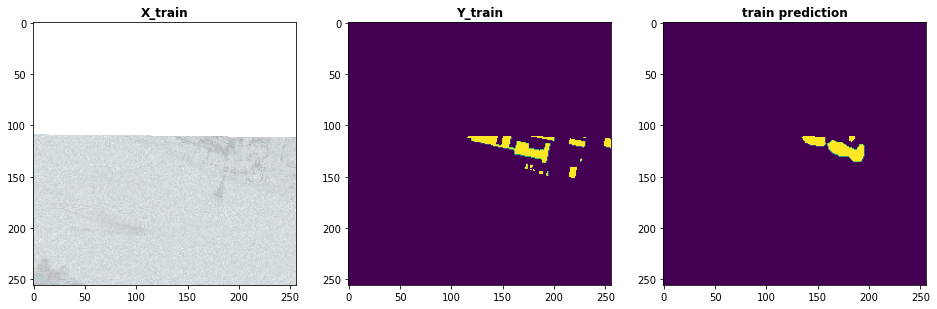

index: 40
val preds  set


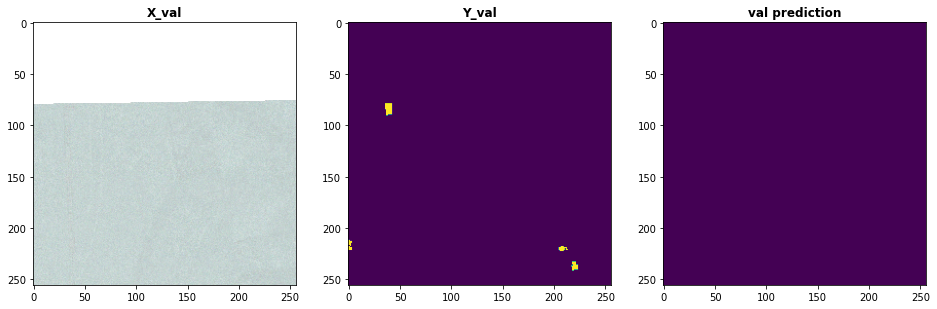

index: 1
test preds  set


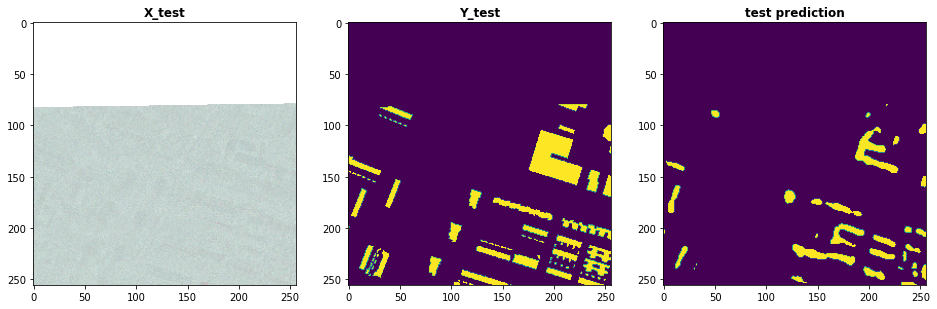

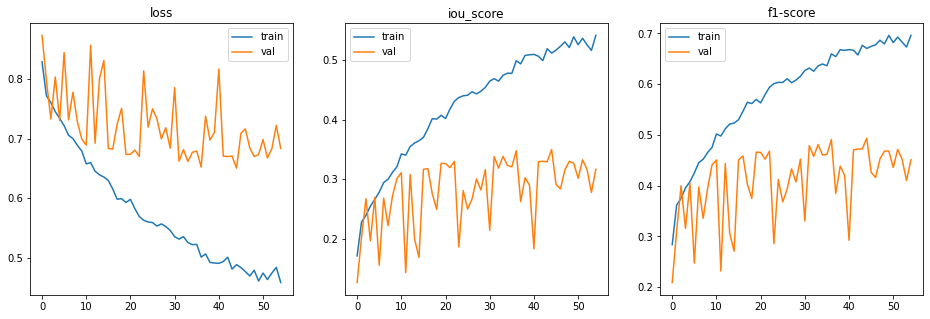

In [ ]:
''' plot predictions to visualize ''' 
plot_XY_preds('train preds', X_train[:MODEL_VAL_OFFSET], Y_train[:MODEL_VAL_OFFSET], preds_train_t, 'X_train', 'Y_train', 'train prediction')
plot_XY_preds('val preds', X_train[MODEL_VAL_OFFSET:], Y_train[MODEL_VAL_OFFSET:], preds_val_t, 'X_val', 'Y_val', 'val prediction')
plot_XY_preds('test preds', X_test, Y_test, preds_test_t, 'X_test', 'Y_test', 'test prediction')
if results != None:
  plot_history(results.history)

### ID 122. BinaryCELoss()

In [ ]:
''' set the train/test ''' 
IMG_TYPE, IMG_WIDTH, IMG_HEIGHT, IMG_ROTATED, IMG_CHANNELS, IMG_DTYPE_SRC, IMG_DTYPE = gen_input_image_details('SAR-Intensity', False)       # CHANGE HERE
PATH_SRC, PATH_SRC_IMAGE, PATH_SRC_MASK, PATH_DATA, PATH_IMAGE, PATH_MASK, PATH_SAMPLE, PATH_SAVED_MODELS = gen_paths(IMG_TYPE, IMG_ROTATED)
if IMG_ROTATED:
  X_train, Y_train, X_test, Y_test = X_train_rotate, Y_train_rotate, X_test_rotate, Y_test_rotate
else:
  X_train, Y_train, X_test, Y_test = X_train_no_rotate, Y_train_no_rotate, X_test_no_rotate, Y_test_no_rotate

gen_input_image_details()
IMG_TYPE: SAR-Intensity, IMG_HEIGHT: 256, IMG_WIDTH: 256, IMG_ROTATED: False, IMG_CHANNELS: 4, IMG_DTYPE_SRC: <class 'numpy.float32'>, IMG_DTYPE: <class 'numpy.uint8'>

gen_paths()
PATH_SRC: /content/gdrive/My Drive/Colab Notebooks/spacenet6/spacenet6_data_BACKUP/train_all/AOI_11_Rotterdam, 
PATH_SRC_IMAGE: /content/gdrive/My Drive/Colab Notebooks/spacenet6/spacenet6_data_BACKUP/train_all/AOI_11_Rotterdam/SAR-Intensity, 
PATH_SRC_MASK: /content/gdrive/My Drive/Colab Notebooks/spacenet6/spacenet6_data_BACKUP/train_all/AOI_11_Rotterdam/_mask, 
PATH_DATA: /content/gdrive/My Drive/Colab Notebooks/spacenet6/spacenet6_data/SAR-Intensity_256x256, 
PATH_IMAGE: /content/gdrive/My Drive/Colab Notebooks/spacenet6/spacenet6_data/SAR-Intensity_256x256/image, 
PATH_MASK: /content/gdrive/My Drive/Colab Notebooks/spacenet6/spacenet6_data/SAR-Intensity_256x256/mask, 
PATH_SAMPLE: /content/gdrive/My Drive/Colab Notebooks/spacenet6/spacenet6_data/SAR-Intensity_256x256/sample, 
P

In [ ]:
''' set the model parameters, train model '''
MODEL_OPTIMIZER, MODEL_LOSS, MODEL_METRICS, MODEL_VAL_SPLIT, MODEL_VAL_OFFSET, MODEL_BATCH_SIZE, MODEL_EPOCHS, MODEL_TYPE, MODEL_PRETRAIN, MODEL_LOSS_FUNCTION, MODEL_COMMENTS, MODEL_ID, MODEL_NAME, model = gen_model(
    BinaryCELoss(), 4, 100, 'segmentation-models Unet', 'efficientnetb0', 'BinaryCELoss()', IMG_CHANNELS, MODEL_ID=122, MODEL_COMMENTS='BinaryCELoss test, early stopping patience 10')          # CHANGE HERE

results, model = gen_model_results(PATH_SAVED_MODELS, MODEL_NAME, X_train, Y_train, MODEL_BATCH_SIZE, MODEL_EPOCHS, MODEL_VAL_SPLIT, 
                                   load_weights_filename='', load_weights_epochs=0, save_model=True)                                            # CHANGE HERE

/usr/local/lib/python3.6/dist-packages/keras_applications/imagenet_utils.py:279: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 4 input channels.
  str(input_shape[-1]) + ' input channels.')


No weights loaded. Training new model
Train on 720 samples, validate on 80 samples
Epoch 1/100
720/720 [==============================] - 50s 70ms/step - loss: 0.8464 - iou_score: 0.1536 - f1-score: 0.2589 - val_loss: 0.9774 - val_iou_score: 0.0226 - val_f1-score: 0.0437
Epoch 2/100
720/720 [==============================] - 33s 45ms/step - loss: 0.7768 - iou_score: 0.2232 - f1-score: 0.3549 - val_loss: 0.9489 - val_iou_score: 0.0511 - val_f1-score: 0.0935
Epoch 3/100
720/720 [==============================] - 33s 45ms/step - loss: 0.7571 - iou_score: 0.2429 - f1-score: 0.3814 - val_loss: 0.8425 - val_iou_score: 0.1575 - val_f1-score: 0.2558
Epoch 4/100
720/720 [==============================] - 33s 45ms/step - loss: 0.7516 - iou_score: 0.2484 - f1-score: 0.3876 - val_loss: 0.9094 - val_iou_score: 0.0906 - val_f1-score: 0.1562
Epoch 5/100
720/720 [==============================] - 33s 46ms/step - loss: 0.7333 - iou_score: 0.2667 - f1-score: 0.4107 - val_loss: 0.7284 - val_iou_score: 0.

In [ ]:
''' predict using model '''
preds_train_t, preds_val_t, preds_test_t = gen_predictions(model, X_train, Y_train, X_test, Y_test, MODEL_VAL_OFFSET, IMG_TYPE, IMG_ROTATED, MODEL_NAME, MODEL_TYPE, MODEL_PRETRAIN, MODEL_LOSS_FUNCTION, MODEL_COMMENTS, MODEL_BATCH_SIZE, MODEL_EPOCHS)

80/80 [==============================] - 1s 7ms/step
train set evaluation
720/720 [==============================] - 5s 8ms/step
loss :  0.4342665526602003
iou_score :  0.5657187104225159
f1-score :  0.7217772006988525

validation set evaluation
80/80 [==============================] - 1s 8ms/step
loss :  0.8631037831306457
iou_score :  0.14635752141475677
f1-score :  0.25357940793037415

test set evaluation
80/80 [==============================] - 1s 8ms/step
loss :  0.5811087369918824
iou_score :  0.4278215169906616
f1-score :  0.598585844039917
saved model metrics


index: 293
train preds  set


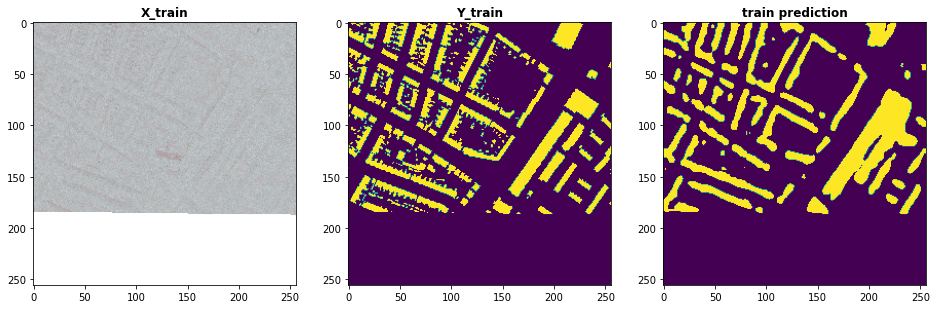

index: 35
val preds  set


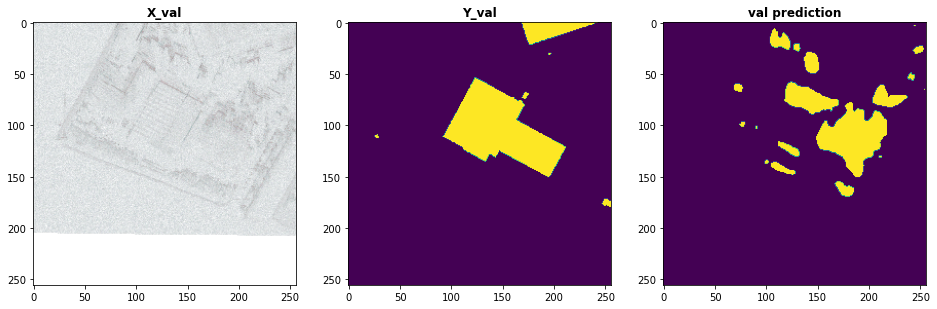

index: 4
test preds  set


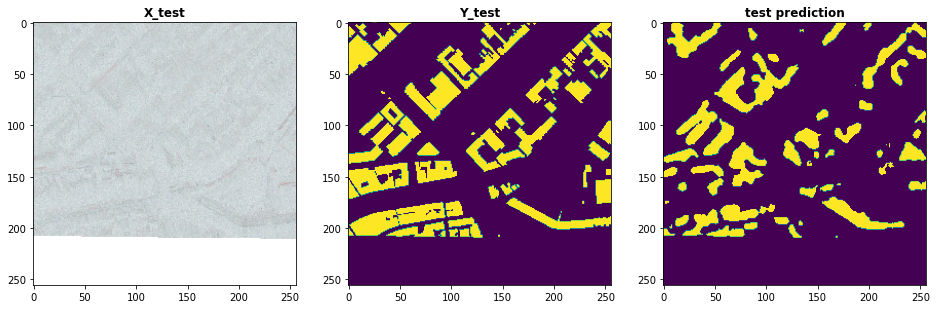

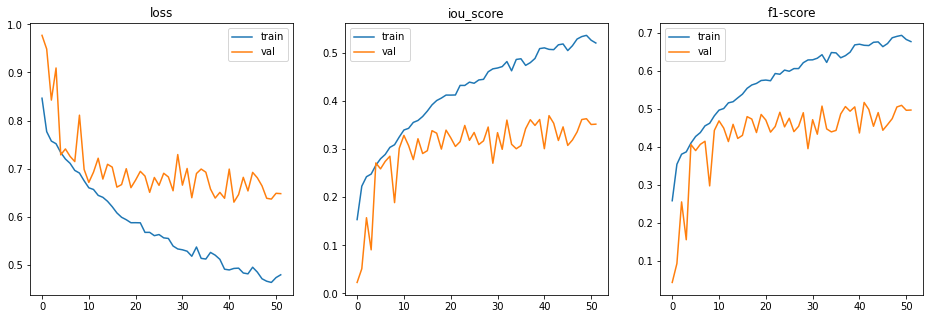

In [ ]:
''' plot predictions to visualize ''' 
plot_XY_preds('train preds', X_train[:MODEL_VAL_OFFSET], Y_train[:MODEL_VAL_OFFSET], preds_train_t, 'X_train', 'Y_train', 'train prediction')
plot_XY_preds('val preds', X_train[MODEL_VAL_OFFSET:], Y_train[MODEL_VAL_OFFSET:], preds_val_t, 'X_val', 'Y_val', 'val prediction')
plot_XY_preds('test preds', X_test, Y_test, preds_test_t, 'X_test', 'Y_test', 'test prediction')
if results != None:
  plot_history(results.history)

### ID 123. BinaryCELoss()

In [ ]:
''' set the train/test ''' 
IMG_TYPE, IMG_WIDTH, IMG_HEIGHT, IMG_ROTATED, IMG_CHANNELS, IMG_DTYPE_SRC, IMG_DTYPE = gen_input_image_details('SAR-Intensity', False)       # CHANGE HERE
PATH_SRC, PATH_SRC_IMAGE, PATH_SRC_MASK, PATH_DATA, PATH_IMAGE, PATH_MASK, PATH_SAMPLE, PATH_SAVED_MODELS = gen_paths(IMG_TYPE, IMG_ROTATED)
if IMG_ROTATED:
  X_train, Y_train, X_test, Y_test = X_train_rotate, Y_train_rotate, X_test_rotate, Y_test_rotate
else:
  X_train, Y_train, X_test, Y_test = X_train_no_rotate, Y_train_no_rotate, X_test_no_rotate, Y_test_no_rotate

gen_input_image_details()
IMG_TYPE: SAR-Intensity, IMG_HEIGHT: 256, IMG_WIDTH: 256, IMG_ROTATED: False, IMG_CHANNELS: 4, IMG_DTYPE_SRC: <class 'numpy.float32'>, IMG_DTYPE: <class 'numpy.uint8'>

gen_paths()
PATH_SRC: /content/gdrive/My Drive/Colab Notebooks/spacenet6/spacenet6_data_BACKUP/train_all/AOI_11_Rotterdam, 
PATH_SRC_IMAGE: /content/gdrive/My Drive/Colab Notebooks/spacenet6/spacenet6_data_BACKUP/train_all/AOI_11_Rotterdam/SAR-Intensity, 
PATH_SRC_MASK: /content/gdrive/My Drive/Colab Notebooks/spacenet6/spacenet6_data_BACKUP/train_all/AOI_11_Rotterdam/_mask, 
PATH_DATA: /content/gdrive/My Drive/Colab Notebooks/spacenet6/spacenet6_data/SAR-Intensity_256x256, 
PATH_IMAGE: /content/gdrive/My Drive/Colab Notebooks/spacenet6/spacenet6_data/SAR-Intensity_256x256/image, 
PATH_MASK: /content/gdrive/My Drive/Colab Notebooks/spacenet6/spacenet6_data/SAR-Intensity_256x256/mask, 
PATH_SAMPLE: /content/gdrive/My Drive/Colab Notebooks/spacenet6/spacenet6_data/SAR-Intensity_256x256/sample, 
P

In [ ]:
''' set the model parameters, train model '''
MODEL_OPTIMIZER, MODEL_LOSS, MODEL_METRICS, MODEL_VAL_SPLIT, MODEL_VAL_OFFSET, MODEL_BATCH_SIZE, MODEL_EPOCHS, MODEL_TYPE, MODEL_PRETRAIN, MODEL_LOSS_FUNCTION, MODEL_COMMENTS, MODEL_ID, MODEL_NAME, model = gen_model(
    BinaryCELoss(), 4, 100, 'segmentation-models Unet', 'efficientnetb0', 'BinaryCELoss()', IMG_CHANNELS, MODEL_ID=123, MODEL_COMMENTS='BinaryCELoss test, early stopping patience 10')          # CHANGE HERE

results, model = gen_model_results(PATH_SAVED_MODELS, MODEL_NAME, X_train, Y_train, MODEL_BATCH_SIZE, MODEL_EPOCHS, MODEL_VAL_SPLIT, 
                                   load_weights_filename='', load_weights_epochs=0, save_model=True)                                            # CHANGE HERE

/usr/local/lib/python3.6/dist-packages/keras_applications/imagenet_utils.py:279: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 4 input channels.
  str(input_shape[-1]) + ' input channels.')


No weights loaded. Training new model
Train on 720 samples, validate on 80 samples
Epoch 1/100
720/720 [==============================] - 51s 71ms/step - loss: 0.8374 - iou_score: 0.1626 - f1-score: 0.2711 - val_loss: 0.8835 - val_iou_score: 0.1165 - val_f1-score: 0.1990
Epoch 2/100
720/720 [==============================] - 33s 46ms/step - loss: 0.7756 - iou_score: 0.2244 - f1-score: 0.3582 - val_loss: 0.7440 - val_iou_score: 0.2560 - val_f1-score: 0.3851
Epoch 3/100
720/720 [==============================] - 33s 46ms/step - loss: 0.7542 - iou_score: 0.2458 - f1-score: 0.3838 - val_loss: 0.8369 - val_iou_score: 0.1631 - val_f1-score: 0.2567
Epoch 4/100
720/720 [==============================] - 33s 46ms/step - loss: 0.7380 - iou_score: 0.2620 - f1-score: 0.4051 - val_loss: 0.8673 - val_iou_score: 0.1327 - val_f1-score: 0.2099
Epoch 5/100
720/720 [==============================] - 33s 46ms/step - loss: 0.7249 - iou_score: 0.2751 - f1-score: 0.4220 - val_loss: 0.8068 - val_iou_score: 0.

In [ ]:
''' predict using model '''
preds_train_t, preds_val_t, preds_test_t = gen_predictions(model, X_train, Y_train, X_test, Y_test, MODEL_VAL_OFFSET, IMG_TYPE, IMG_ROTATED, MODEL_NAME, MODEL_TYPE, MODEL_PRETRAIN, MODEL_LOSS_FUNCTION, MODEL_COMMENTS, MODEL_BATCH_SIZE, MODEL_EPOCHS)

80/80 [==============================] - 1s 8ms/step
train set evaluation
720/720 [==============================] - 5s 8ms/step
loss :  0.5495314068264432
iou_score :  0.4500775635242462
f1-score :  0.6190769076347351

validation set evaluation
80/80 [==============================] - 1s 8ms/step
loss :  0.8804551124572754
iou_score :  0.13107597827911377
f1-score :  0.22918915748596191

test set evaluation
80/80 [==============================] - 1s 7ms/step
loss :  0.6245180249214173
iou_score :  0.38413500785827637
f1-score :  0.5542926788330078
saved model metrics


index: 210
train preds  set


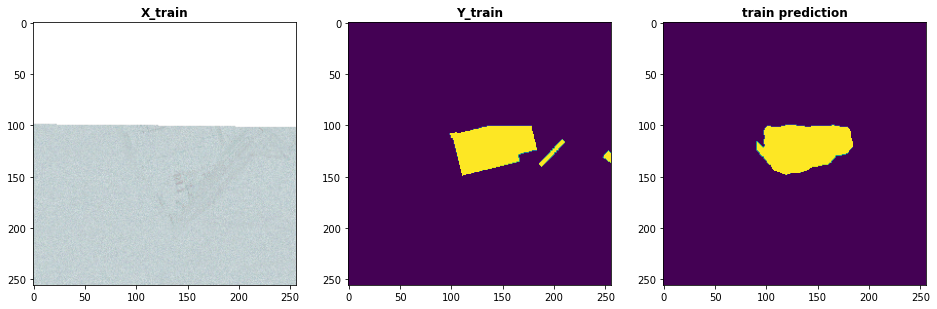

index: 16
val preds  set


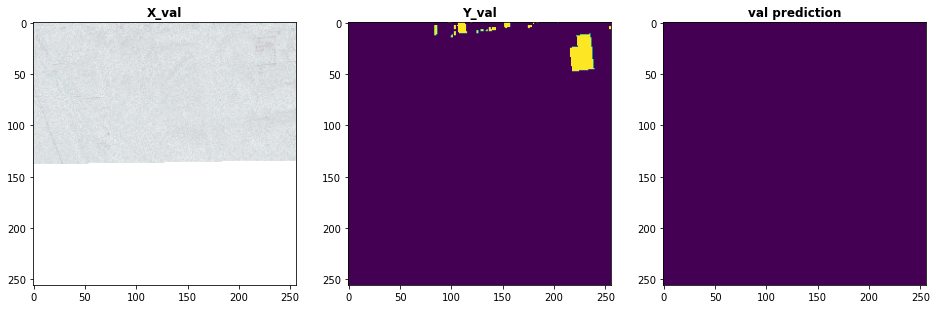

index: 26
test preds  set


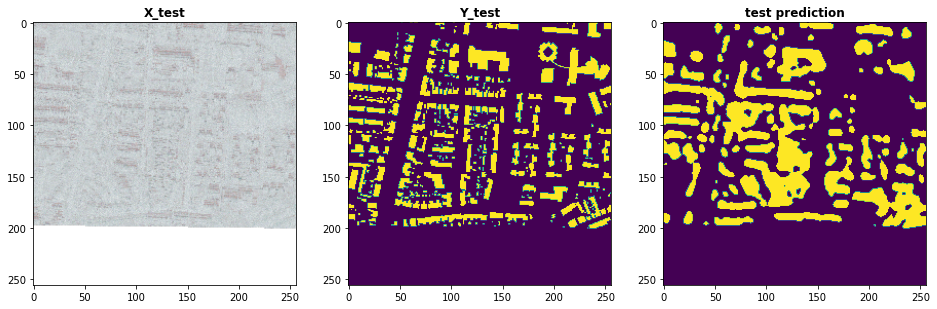

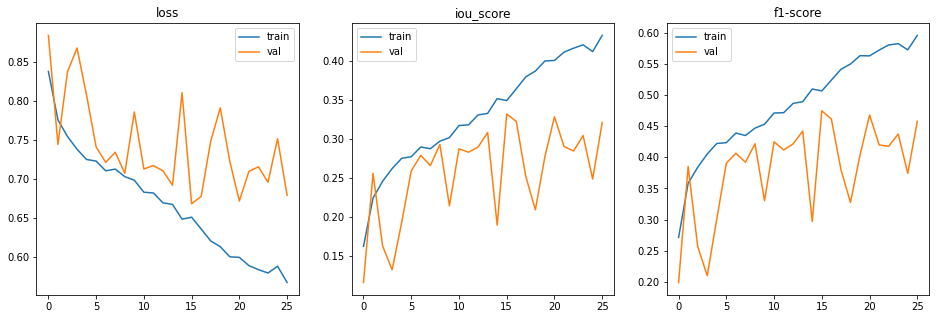

In [ ]:
''' plot predictions to visualize ''' 
plot_XY_preds('train preds', X_train[:MODEL_VAL_OFFSET], Y_train[:MODEL_VAL_OFFSET], preds_train_t, 'X_train', 'Y_train', 'train prediction')
plot_XY_preds('val preds', X_train[MODEL_VAL_OFFSET:], Y_train[MODEL_VAL_OFFSET:], preds_val_t, 'X_val', 'Y_val', 'val prediction')
plot_XY_preds('test preds', X_test, Y_test, preds_test_t, 'X_test', 'Y_test', 'test prediction')
if results != None:
  plot_history(results.history)

### ID 124. BinaryCELoss()

In [ ]:
''' set the train/test ''' 
IMG_TYPE, IMG_WIDTH, IMG_HEIGHT, IMG_ROTATED, IMG_CHANNELS, IMG_DTYPE_SRC, IMG_DTYPE = gen_input_image_details('SAR-Intensity', False)       # CHANGE HERE
PATH_SRC, PATH_SRC_IMAGE, PATH_SRC_MASK, PATH_DATA, PATH_IMAGE, PATH_MASK, PATH_SAMPLE, PATH_SAVED_MODELS = gen_paths(IMG_TYPE, IMG_ROTATED)
if IMG_ROTATED:
  X_train, Y_train, X_test, Y_test = X_train_rotate, Y_train_rotate, X_test_rotate, Y_test_rotate
else:
  X_train, Y_train, X_test, Y_test = X_train_no_rotate, Y_train_no_rotate, X_test_no_rotate, Y_test_no_rotate

gen_input_image_details()
IMG_TYPE: SAR-Intensity, IMG_HEIGHT: 256, IMG_WIDTH: 256, IMG_ROTATED: False, IMG_CHANNELS: 4, IMG_DTYPE_SRC: <class 'numpy.float32'>, IMG_DTYPE: <class 'numpy.uint8'>

gen_paths()
PATH_SRC: /content/gdrive/My Drive/Colab Notebooks/spacenet6/spacenet6_data_BACKUP/train_all/AOI_11_Rotterdam, 
PATH_SRC_IMAGE: /content/gdrive/My Drive/Colab Notebooks/spacenet6/spacenet6_data_BACKUP/train_all/AOI_11_Rotterdam/SAR-Intensity, 
PATH_SRC_MASK: /content/gdrive/My Drive/Colab Notebooks/spacenet6/spacenet6_data_BACKUP/train_all/AOI_11_Rotterdam/_mask, 
PATH_DATA: /content/gdrive/My Drive/Colab Notebooks/spacenet6/spacenet6_data/SAR-Intensity_256x256, 
PATH_IMAGE: /content/gdrive/My Drive/Colab Notebooks/spacenet6/spacenet6_data/SAR-Intensity_256x256/image, 
PATH_MASK: /content/gdrive/My Drive/Colab Notebooks/spacenet6/spacenet6_data/SAR-Intensity_256x256/mask, 
PATH_SAMPLE: /content/gdrive/My Drive/Colab Notebooks/spacenet6/spacenet6_data/SAR-Intensity_256x256/sample, 
P

In [ ]:
''' set the model parameters, train model '''
MODEL_OPTIMIZER, MODEL_LOSS, MODEL_METRICS, MODEL_VAL_SPLIT, MODEL_VAL_OFFSET, MODEL_BATCH_SIZE, MODEL_EPOCHS, MODEL_TYPE, MODEL_PRETRAIN, MODEL_LOSS_FUNCTION, MODEL_COMMENTS, MODEL_ID, MODEL_NAME, model = gen_model(
    BinaryCELoss(), 4, 100, 'segmentation-models Unet', 'efficientnetb0', 'BinaryCELoss()', IMG_CHANNELS, MODEL_ID=124, MODEL_COMMENTS='BinaryCELoss test, early stopping patience 10')          # CHANGE HERE

results, model = gen_model_results(PATH_SAVED_MODELS, MODEL_NAME, X_train, Y_train, MODEL_BATCH_SIZE, MODEL_EPOCHS, MODEL_VAL_SPLIT, 
                                   load_weights_filename='', load_weights_epochs=0, save_model=True)                                            # CHANGE HERE

/usr/local/lib/python3.6/dist-packages/keras_applications/imagenet_utils.py:279: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 4 input channels.
  str(input_shape[-1]) + ' input channels.')


No weights loaded. Training new model
Train on 720 samples, validate on 80 samples
Epoch 1/100
720/720 [==============================] - 96s 133ms/step - loss: 0.8338 - iou_score: 0.1662 - f1-score: 0.2774 - val_loss: 0.9004 - val_iou_score: 0.0996 - val_f1-score: 0.1733
Epoch 2/100
720/720 [==============================] - 64s 89ms/step - loss: 0.7743 - iou_score: 0.2257 - f1-score: 0.3595 - val_loss: 0.7934 - val_iou_score: 0.2066 - val_f1-score: 0.3224
Epoch 3/100
720/720 [==============================] - 65s 90ms/step - loss: 0.7618 - iou_score: 0.2382 - f1-score: 0.3754 - val_loss: 0.9727 - val_iou_score: 0.0273 - val_f1-score: 0.0466
Epoch 4/100
720/720 [==============================] - 65s 90ms/step - loss: 0.7499 - iou_score: 0.2501 - f1-score: 0.3905 - val_loss: 0.8561 - val_iou_score: 0.1439 - val_f1-score: 0.2297
Epoch 5/100
720/720 [==============================] - 64s 90ms/step - loss: 0.7371 - iou_score: 0.2629 - f1-score: 0.4050 - val_loss: 0.7213 - val_iou_score: 0

In [ ]:
''' predict using model '''
preds_train_t, preds_val_t, preds_test_t = gen_predictions(model, X_train, Y_train, X_test, Y_test, MODEL_VAL_OFFSET, IMG_TYPE, IMG_ROTATED, MODEL_NAME, MODEL_TYPE, MODEL_PRETRAIN, MODEL_LOSS_FUNCTION, MODEL_COMMENTS, MODEL_BATCH_SIZE, MODEL_EPOCHS)

80/80 [==============================] - 1s 15ms/step
train set evaluation
720/720 [==============================] - 10s 15ms/step
loss :  0.4352696034643385
iou_score :  0.564094603061676
f1-score :  0.7204722762107849

validation set evaluation
80/80 [==============================] - 1s 16ms/step
loss :  0.9020898938179016
iou_score :  0.10646945983171463
f1-score :  0.1908651441335678

test set evaluation
80/80 [==============================] - 1s 15ms/step
loss :  0.6217635869979858
iou_score :  0.3912157118320465
f1-score :  0.5606924891471863
saved model metrics


index: 647
train preds  set


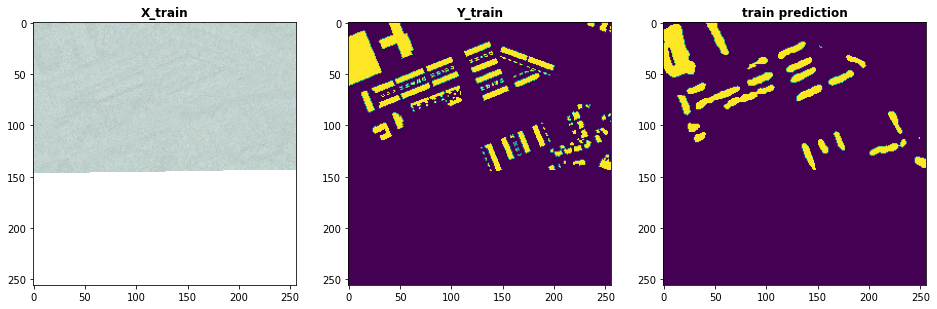

index: 54
val preds  set


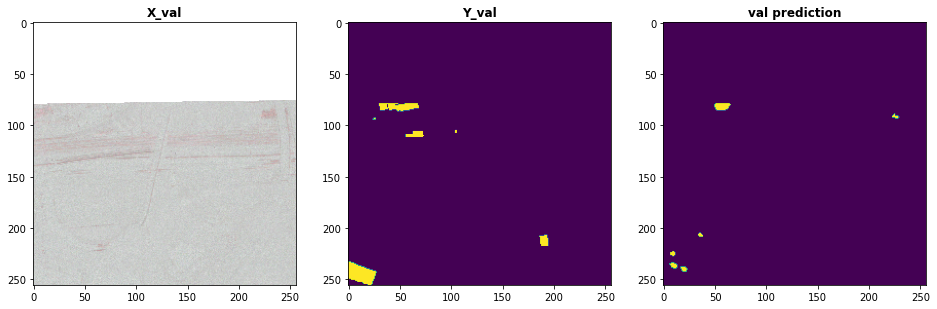

index: 4
test preds  set


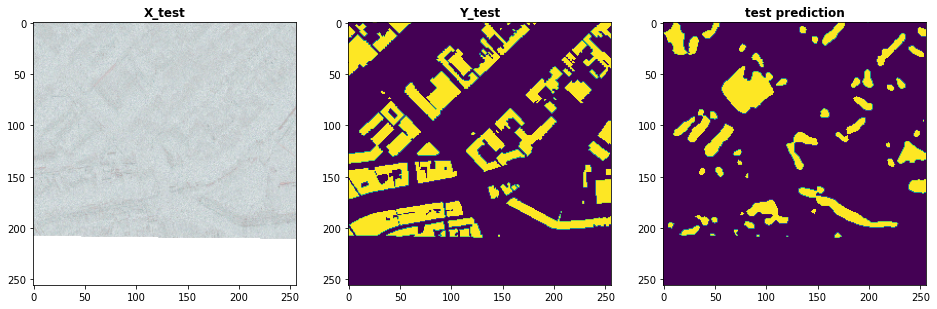

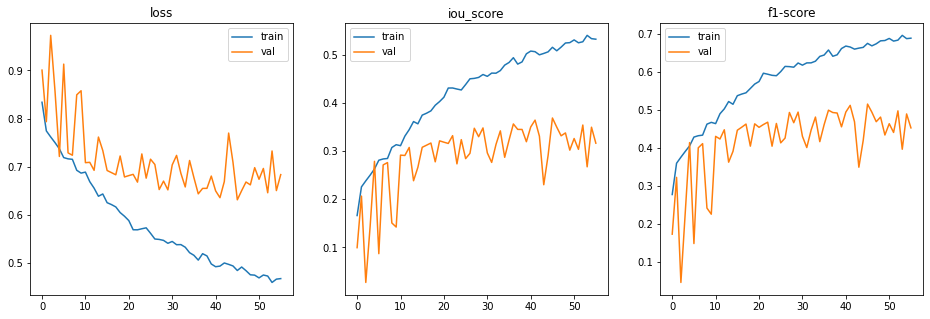

In [ ]:
''' plot predictions to visualize ''' 
plot_XY_preds('train preds', X_train[:MODEL_VAL_OFFSET], Y_train[:MODEL_VAL_OFFSET], preds_train_t, 'X_train', 'Y_train', 'train prediction')
plot_XY_preds('val preds', X_train[MODEL_VAL_OFFSET:], Y_train[MODEL_VAL_OFFSET:], preds_val_t, 'X_val', 'Y_val', 'val prediction')
plot_XY_preds('test preds', X_test, Y_test, preds_test_t, 'X_test', 'Y_test', 'test prediction')
if results != None:
  plot_history(results.history)

### ID 125. BinaryCELoss()

In [ ]:
''' set the train/test ''' 
IMG_TYPE, IMG_WIDTH, IMG_HEIGHT, IMG_ROTATED, IMG_CHANNELS, IMG_DTYPE_SRC, IMG_DTYPE = gen_input_image_details('SAR-Intensity', False)       # CHANGE HERE
PATH_SRC, PATH_SRC_IMAGE, PATH_SRC_MASK, PATH_DATA, PATH_IMAGE, PATH_MASK, PATH_SAMPLE, PATH_SAVED_MODELS = gen_paths(IMG_TYPE, IMG_ROTATED)
if IMG_ROTATED:
  X_train, Y_train, X_test, Y_test = X_train_rotate, Y_train_rotate, X_test_rotate, Y_test_rotate
else:
  X_train, Y_train, X_test, Y_test = X_train_no_rotate, Y_train_no_rotate, X_test_no_rotate, Y_test_no_rotate

gen_input_image_details()
IMG_TYPE: SAR-Intensity, IMG_HEIGHT: 256, IMG_WIDTH: 256, IMG_ROTATED: False, IMG_CHANNELS: 4, IMG_DTYPE_SRC: <class 'numpy.float32'>, IMG_DTYPE: <class 'numpy.uint8'>

gen_paths()
PATH_SRC: /content/gdrive/My Drive/Colab Notebooks/spacenet6/spacenet6_data_BACKUP/train_all/AOI_11_Rotterdam, 
PATH_SRC_IMAGE: /content/gdrive/My Drive/Colab Notebooks/spacenet6/spacenet6_data_BACKUP/train_all/AOI_11_Rotterdam/SAR-Intensity, 
PATH_SRC_MASK: /content/gdrive/My Drive/Colab Notebooks/spacenet6/spacenet6_data_BACKUP/train_all/AOI_11_Rotterdam/_mask, 
PATH_DATA: /content/gdrive/My Drive/Colab Notebooks/spacenet6/spacenet6_data/SAR-Intensity_256x256, 
PATH_IMAGE: /content/gdrive/My Drive/Colab Notebooks/spacenet6/spacenet6_data/SAR-Intensity_256x256/image, 
PATH_MASK: /content/gdrive/My Drive/Colab Notebooks/spacenet6/spacenet6_data/SAR-Intensity_256x256/mask, 
PATH_SAMPLE: /content/gdrive/My Drive/Colab Notebooks/spacenet6/spacenet6_data/SAR-Intensity_256x256/sample, 
P

In [ ]:
''' set the model parameters, train model '''
MODEL_OPTIMIZER, MODEL_LOSS, MODEL_METRICS, MODEL_VAL_SPLIT, MODEL_VAL_OFFSET, MODEL_BATCH_SIZE, MODEL_EPOCHS, MODEL_TYPE, MODEL_PRETRAIN, MODEL_LOSS_FUNCTION, MODEL_COMMENTS, MODEL_ID, MODEL_NAME, model = gen_model(
    BinaryCELoss(), 4, 100, 'segmentation-models Unet', 'efficientnetb0', 'BinaryCELoss()', IMG_CHANNELS, MODEL_ID=125, MODEL_COMMENTS='BinaryCELoss test, early stopping patience 10')          # CHANGE HERE

results, model = gen_model_results(PATH_SAVED_MODELS, MODEL_NAME, X_train, Y_train, MODEL_BATCH_SIZE, MODEL_EPOCHS, MODEL_VAL_SPLIT, 
                                   load_weights_filename='', load_weights_epochs=0, save_model=True)                                            # CHANGE HERE

/usr/local/lib/python3.6/dist-packages/keras_applications/imagenet_utils.py:279: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 4 input channels.
  str(input_shape[-1]) + ' input channels.')


No weights loaded. Training new model
Train on 720 samples, validate on 80 samples
Epoch 1/100
720/720 [==============================] - 88s 122ms/step - loss: 0.8291 - iou_score: 0.1709 - f1-score: 0.2829 - val_loss: 0.9142 - val_iou_score: 0.0858 - val_f1-score: 0.1538
Epoch 2/100
720/720 [==============================] - 72s 100ms/step - loss: 0.7768 - iou_score: 0.2232 - f1-score: 0.3556 - val_loss: 0.8407 - val_iou_score: 0.1593 - val_f1-score: 0.2647
Epoch 3/100
720/720 [==============================] - 65s 90ms/step - loss: 0.7627 - iou_score: 0.2373 - f1-score: 0.3735 - val_loss: 0.7551 - val_iou_score: 0.2449 - val_f1-score: 0.3716
Epoch 4/100
720/720 [==============================] - 65s 90ms/step - loss: 0.7499 - iou_score: 0.2501 - f1-score: 0.3899 - val_loss: 0.7611 - val_iou_score: 0.2389 - val_f1-score: 0.3655
Epoch 5/100
720/720 [==============================] - 65s 90ms/step - loss: 0.7329 - iou_score: 0.2671 - f1-score: 0.4121 - val_loss: 0.7291 - val_iou_score: 

In [ ]:
''' predict using model '''
preds_train_t, preds_val_t, preds_test_t = gen_predictions(model, X_train, Y_train, X_test, Y_test, MODEL_VAL_OFFSET, IMG_TYPE, IMG_ROTATED, MODEL_NAME, MODEL_TYPE, MODEL_PRETRAIN, MODEL_LOSS_FUNCTION, MODEL_COMMENTS, MODEL_BATCH_SIZE, MODEL_EPOCHS)

80/80 [==============================] - 1s 14ms/step
train set evaluation
720/720 [==============================] - 10s 15ms/step
loss :  0.4303237583902147
iou_score :  0.5698295831680298
f1-score :  0.7252667546272278

validation set evaluation
80/80 [==============================] - 1s 16ms/step
loss :  0.8319347381591797
iou_score :  0.18147604167461395
f1-score :  0.304127961397171

test set evaluation
80/80 [==============================] - 1s 15ms/step
loss :  0.5665557146072387
iou_score :  0.44066953659057617
f1-score :  0.6112372279167175
saved model metrics


index: 277
train preds  set


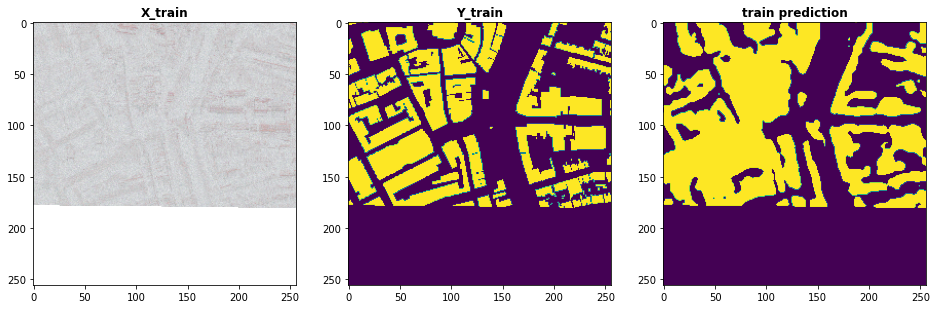

index: 16
val preds  set


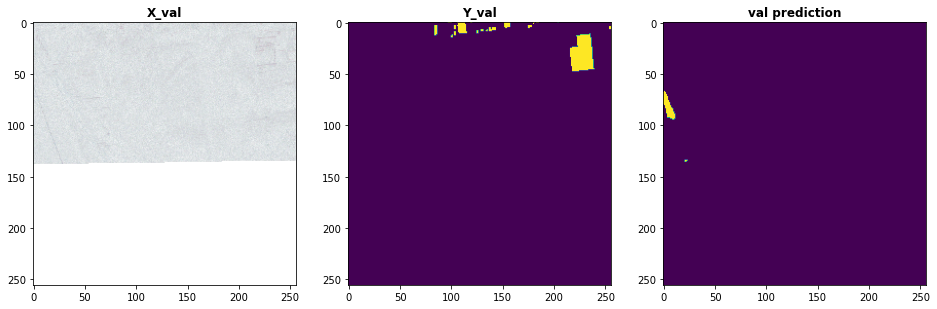

index: 34
test preds  set


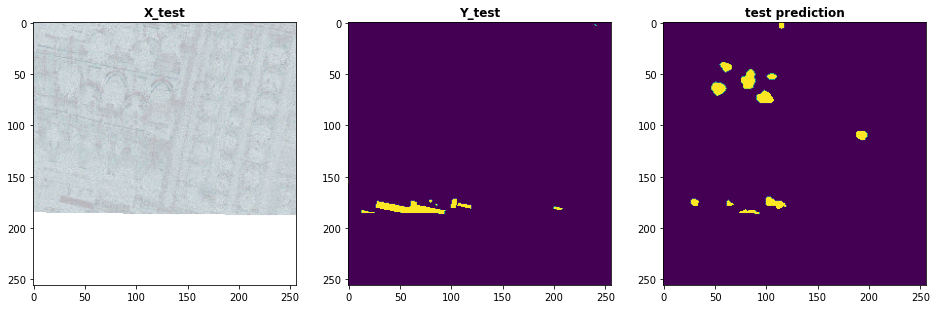

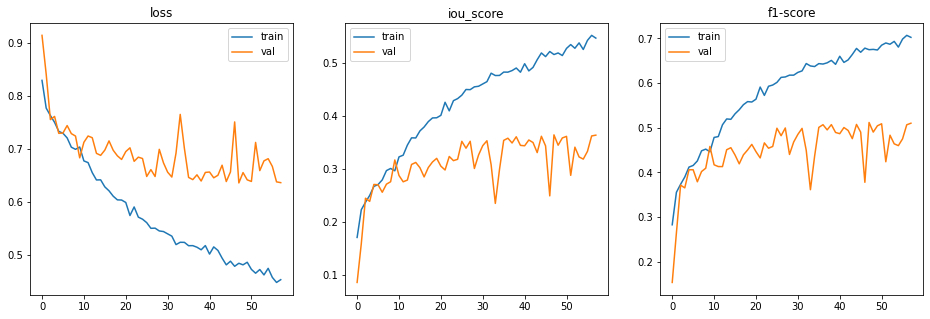

In [ ]:
''' plot predictions to visualize ''' 
plot_XY_preds('train preds', X_train[:MODEL_VAL_OFFSET], Y_train[:MODEL_VAL_OFFSET], preds_train_t, 'X_train', 'Y_train', 'train prediction')
plot_XY_preds('val preds', X_train[MODEL_VAL_OFFSET:], Y_train[MODEL_VAL_OFFSET:], preds_val_t, 'X_val', 'Y_val', 'val prediction')
plot_XY_preds('test preds', X_test, Y_test, preds_test_t, 'X_test', 'Y_test', 'test prediction')
if results != None:
  plot_history(results.history)

## Findings

BinaryCELoss performance is somewhat erratic, doesn't show a trend. But it can do very well also